In [2]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from scipy import spatial

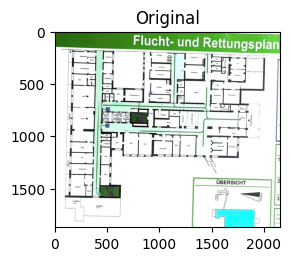

In [3]:
image = cv2.imread('/home/sagar/Monorepo/src/preprocessing/py/map_cleaner/modified_image_cleanup(1)_cleanup(1)_cleanup_cleanup_cropped.jpg')
plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(image)

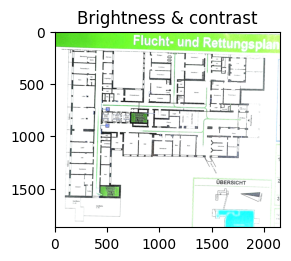

In [4]:
brightness = 1
# Adjusts the contrast by scaling the pixel values by 2.3
contrast = 2 
image2 = cv2.addWeighted(image, contrast, np.zeros(image.shape, image.dtype), 0, brightness)
kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
sharpened_image = cv2.filter2D(image2, -1, kernel)
#Save the image
cv2.imwrite('modified_image_cropped.jpg', sharpened_image)
#Plot the contrast image
plt.subplot(1, 2, 2)
plt.title("Brightness & contrast")
plt.imshow(image2)
plt.show()

In [6]:
from sklearn.cluster import KMeans

number_of_colors = 10
modified_image = image.reshape(image.shape[0]*image.shape[1], 3)
clf = KMeans(n_clusters = number_of_colors)
labels = clf.fit_predict(modified_image)

/home/sagar/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


([<matplotlib.patches.Wedge at 0x7fc78c28e230>,
 [Text(1.09843693626754, 0.05861993724988636, '#36821a'),
  Text(1.0863809137248532, 0.1725587154980968, '#62c93d'),
  Text(1.0476678422916441, 0.33524929862412983, '#8ccaf5'),
  Text(0.9879245058138284, 0.4837408095380243, '#1989e3'),
  Text(0.9005319779450955, 0.631697836547106, '#90b994'),
  Text(-1.095105039000147, -0.10365786779828443, '#3a4952'),
  Text(0.9680399736318155, -0.5223969845346681, '#fdfefe'),
  Text(1.00100510208524, -0.45605787527387187, '#ccf6eb'),
  Text(1.0500583104268018, -0.327685130427993, '#20fefe'),
  Text(1.0942436571704182, -0.1123869153518702, '#060d0c')])

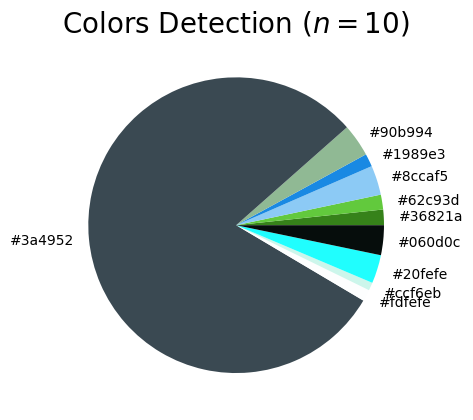

In [9]:
from collections import Counter

def RGB2HEX(color):
    return "#{:02x}{:02x}{:02x}".format(int(color[0]), int(color[1]), int(color[2]))

counts = Counter(labels)

center_colors = clf.cluster_centers_
# We get ordered colors by iterating through the keys
ordered_colors = [center_colors[i] for i in counts.keys()]
hex_colors = [RGB2HEX(ordered_colors[i]) for i in counts.keys()]
rgb_colors = [ordered_colors[i] for i in counts.keys()]

plt.title('Colors Detection ($n=10$)', fontsize=20)
plt.pie(counts.values(), labels = hex_colors, colors = hex_colors)



In [7]:

from skimage.color import rgb2lab, deltaE_cie76

def get_colors(image, number_of_colors, show_chart):
    
    modified_image = cv2.resize(image, (600, 400), interpolation = cv2.INTER_AREA)
    modified_image = modified_image.reshape(modified_image.shape[0]*modified_image.shape[1], 3)
    
    clf = KMeans(n_clusters = number_of_colors)
    labels = clf.fit_predict(modified_image)
    
    counts = Counter(labels)
    # sort to ensure correct color percentage
    counts = dict(sorted(counts.items()))
    
    center_colors = clf.cluster_centers_
    # We get ordered colors by iterating through the keys
    ordered_colors = [center_colors[i] for i in counts.keys()]
    hex_colors = [RGB2HEX(ordered_colors[i]) for i in counts.keys()]
    rgb_colors = [ordered_colors[i] for i in counts.keys()]

    if (show_chart):
        plt.figure(figsize = (8, 6))
        plt.pie(counts.values(), labels = hex_colors, colors = hex_colors)
    
    return rgb_colors


def match_image_by_color(image, color, threshold = 60, number_of_colors = 10): 
    
    image_colors = get_colors(image, number_of_colors, False)
    selected_color = rgb2lab(np.uint8(np.asarray([[color]])))

    select_image = False
    for i in range(number_of_colors):
        curr_color = rgb2lab(np.uint8(np.asarray([[image_colors[i]]])))
        diff = deltaE_cie76(selected_color, curr_color)
        if (diff < threshold):
            select_image = True
    
    return select_image

def show_selected_images(images, color, threshold, colors_to_match):
    index = 1
    
    for i in range(len(images)):
        selected = match_image_by_color(images[i],
                                        color,
                                        threshold,
                                        colors_to_match)
        if (selected):
            plt.subplot(1, 5, index)
            plt.imshow(images[i])
            index += 1

In [8]:
COLORS = {
    'GREEN': [0, 128, 0],
    'BLUE': [0, 0, 128],
    'YELLOW': [255, 255, 0]
}
plt.figure(figsize = (20, 10))
show_selected_images(image, COLORS['GREEN'], 60, 5)

ValueError: cannot reshape array of size 240000 into shape (240000,3)

<Figure size 2000x1000 with 0 Axes>

In [28]:
def convert_yolo_to_instance_segmentation(yolo_labels, image_width, image_height):
    # Initialize an empty mask for instance segmentation
    instance_mask = np.zeros((image_height, image_width), dtype=np.uint8)
    instances = []

    for label in yolo_labels:
        class_id, x_center, y_center, width, height = label
        # Convert YOLO format to absolute coordinates
        x1 = int((x_center - width / 2) * image_width)
        print(x1)
        y1 = int((y_center - height / 2) * image_height)
        x2 = int((x_center + width / 2) * image_width)
        y2 = int((y_center + height / 2) * image_height)

        # Create a mask for the current object instance
        mask = np.zeros((image_height, image_width), dtype=np.uint8)
        mask[y1:y2, x1:x2] = 1

        # Assign a unique ID to the instance and add it to the list
        instance_id = len(instances) + 1
        instances.append((instance_id, class_id, mask))

        # Add the instance mask to the overall instance segmentation mask
        instance_mask[mask == 1] = instance_id

    return instance_mask, instances


In [30]:
yolo_label = [(0,0.287202,0.652116,0.008929,0.016755)]
image_width = image.shape[1]
print(image_width)
image_height = image.shape[0]
convert_yolo_to_instance_segmentation(yolo_label,image_width,image_height)


4032
1139


(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 [(1,
   0,
   array([[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))])

In [22]:
image.shape[0]

2268

In [31]:
edgesx = cv2.Scharr(image, -1, dx=1, dy=0, scale=1, delta=0, borderType=cv2.BORDER_DEFAULT)
edgesy = cv2.Scharr(image, -1, dx=0, dy=1, scale=1, delta=0, borderType=cv2.BORDER_DEFAULT)

edges =  edgesx + edgesy



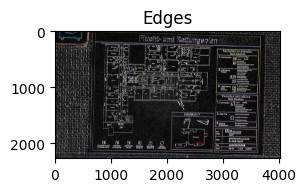

In [36]:
cv2.imwrite('edges.jpg', edges)
plt.subplot(1, 2, 2)
plt.title("Edges")
plt.imshow(edges)
plt.show()

In [37]:
import numpy as np
import skimage


def fmat(img):
    """
    Converts to a feature matrix (N by c)
    """
    try:
        l, w, c = img.shape
        fmat = np.ones((l*w,c)) 
        for i in range(c): fmat[:,i] = np.reshape(img[:,:,i],(l*w,))
    except ValueError:
        try:
            l, w = img.shape
            fmat = np.ones((l*w,1)) 
            fmat = np.reshape(img,(l*w,1))
        except ValueError:
            print("Image should be at least a 2D array.")
    return fmat



def pmat(shape):
    """
    Returns the position feature matrix.
    """
    x = np.arange(0,shape[1],1)
    y = np.arange(shape[0],0,-1)
    meshx, meshy = np.meshgrid(x,y)
    x = np.reshape(meshx,(shape[0]*shape[1],1)) 
    y = np.reshape(meshy,(shape[0]*shape[1],1)) 
    pmat = np.concatenate((x,y),axis=1) / max(shape[0],shape[1])
    return pmat



def to_img(fmat, shape):
    """
    Converts from fmat to img.
    """
    img = np.zeros(shape)
    try:
        l, w, c = img.shape
        for i in range(c): img[:,:,i] = np.reshape(fmat[0:,i],(l,w))
    except ValueError:
        try:
            l, w = img.shape
            img = np.reshape(fmat,(l,w))
        except ValueError:
            print("Image should be at least a 2D array.")
    return img



def create_patches(img, patch_shape=(3,3)):
    try:
        h, w, d = img.shape
    except ValueError:
        try:
            h, w = img.shape
            d = 0
        except ValueError:
            print("Image should be at least a 2D array.")

    try:
        r, c = patch_shape
    except ValueError:
        r = patch_shape[0]
        c = r

    pad_width = [(int((r - 0.5) / 2.), int((r + 0.5) / 2.)),
                 (int((c - 0.5) / 2.), int((c + 0.5) / 2.))]

    if d == 0:
        window_shape = (r, c)
        d = 1  # For the reshape in the return call
    else:
        pad_width += [(0, 0)]
        window_shape = (r, c, d)

    # Pad the image.
    img = np.pad(img, pad_width=pad_width, mode='symmetric')

    # Extract patches as node features.
    # Alternative: sklearn.feature_extraction.image.extract_patches_2d.
    #              sklearn has much less dependencies than skimage.
    try:
        import skimage
    except Exception:
        raise ImportError('Cannot import skimage, which is needed to '
                          'extract patches. Try to install it with '
                          'pip (or conda) install scikit-image.')
    patches = skimage.util.view_as_windows(img, window_shape=window_shape)
    patches = patches.reshape((h * w, r * c * d))
    return patches

In [38]:
class Inpainting:
  """
  Inpaints an image using Dirichlet interpolation.
  Happens to be nlm for p=2 in p laplacian.
  """
  def __init__(self, org_img, mask, ps):
    """
    org_img: path to the original image (rgb or gray)
    mask: path to the mask (binary image, 0,1)
    ps: patch size (used for creating a dynamic non-local graph)
    """
    self.org_img = org_img
    self.mask = mask 
    self.ps = ps

  def __call__(self, k_boundary=4, k_search=1000, k_patch=5):
    """
    k_boundary: used for finding the boundary pixels
    k_search: used for search in the neighborhood of the boundary pixels
    k_patch: used for creating a dynamic non-local graph
    """
    inpainted_img =  self.forward(k_boundary, k_search, k_patch)
    return inpainted_img

  def preprocess(self):
    img = mpimg.imread(self.org_img)
    mask = mpimg.imread(self.mask)
    img = (img - np.min(img))/ (np.max(img) - np.min(img)).astype("float32") + 0.01
    img = (img.T * mask.T).T
    self._shape = img.shape
    position = pmat(self._shape)
    texture = fmat(img)
    self._position = (position - np.min(position) )/ (np.max(position) - np.min(position))
    self._texture = (texture - np.min(texture) )/ (np.max(texture) - np.min(texture))
    self._patches = create_patches(img, (self.ps, self.ps))

  def postprocess(self, fmat):
      return to_img(fmat, self._shape)

  def forward(self, k_boundary, k_search, k_patch):
    self.preprocess()

    kdt = spatial.cKDTree(self._position)
    dA = np.where(self._texture.any(axis=1))[0]
    A = np.where(~self._texture.any(axis=1))[0]

    pbar = tqdm(desc=f"# of pixels to be inpainted are {A.size}", total = A.size, 
            bar_format = '{l_bar}{bar}|{n_fmt}/{total_fmt}')
    while A.size >=1 :
      dmA = np.array([]).astype("int")
      for i in A : 
        _, indices = kdt.query(self._position[i], k_boundary)
        if (~np.isin(indices, A)).any():
          dmA = np.append(dmA,i)
          mask = (~(self._patches[i].flatten() == 0)).astype("int")
          _, indices = kdt.query(self._position[i], k_search)
          part_of_dA = indices[~np.isin(indices,A)]
          new_patches = mask.flatten() * self._patches[part_of_dA]
          kdt_ = spatial.cKDTree(new_patches)
          _, indices= kdt_.query(self._patches[i].flatten(),k_patch)
          ids = part_of_dA[indices]
          self._texture[i] = self._texture[ids].mean(axis=0)
      self._patches = create_patches(to_img(self._texture,(self._shape)),(self.ps,self.ps))
      dA = np.concatenate((dA,dmA), axis=0)
      A = A[~np.isin(A,dmA)]
      #pbar.set_description(desc=f"# of pixels to be inpainted are {A.size}")
      pbar.update(dmA.size)
    pbar.close()
    return self.postprocess(self._texture)


def check_args(cls):
  def correct_args(org_img, mask, ps=7):
    if (isinstance(org_img,str) and isinstance(mask,str) and isinstance(ps,int)):
      return cls(org_img, mask, ps)
    else:
      raise Exception(f"arg[0]:str, arg[1]:str, arg[2]:int")
  return correct_args


Inpaint = check_args(Inpainting)

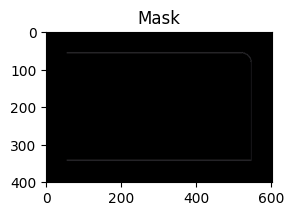

In [14]:
image = cv2.imread('pencil-round-top.jpg')
ret, thresh1 = cv2.threshold(image, 120, 255, cv2.THRESH_BINARY)
ret, thresh2 = cv2.threshold(image, 120, 255, cv2.THRESH_BINARY_INV)
ret, thresh3 = cv2.threshold(image, 120, 255, cv2.THRESH_TRUNC)
ret, thresh4 = cv2.threshold(image, 120, 255, cv2.THRESH_TOZERO)
ret, thresh5 = cv2.threshold(image, 120, 255, cv2.THRESH_TOZERO_INV)
kernel = np.ones((7,7),np.uint8) 
dilated_image = cv2.dilate(image,kernel,iterations = 3) 
plt.subplot(1, 2, 2)
plt.title("Mask")
plt.imshow(thresh5)
plt.show()

